# Introduction
This notebook will create a small solution (NN Model) for the MNIST dataset.
The solution (model) will be exported once with the Keras library and once with ONNX (Open Neural Network Exchange).

# 0. Import statements

In [1]:
import keras
from keras import models
from keras import layers
from keras.datasets import mnist
#from keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

Enable autocomplete (using tab).

In [2]:
%config Completer.use_jedi = False

# 1. Load data

In order to understand what happens in a computer vision model, we first have to understand how computers handle images. We'll use one of the most famous datasets in computer vision, MNIST, for our experiments. MNIST contains images of handwritten digits, collected by the National Institute of Standards and Technology and collated into a machine learning dataset by Yann Lecun and his colleagues. Lecun used MNIST in 1998 in Lenet-5, the first computer system to demonstrate practically useful recognition of handwritten digit sequences. This was one of the most important breakthroughs in the history of AI.

The MNIST database of handwritten digit has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image.
It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting.

In [3]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


# 2. Inspect data

Try to get a feel for the data you are using to train and test your neural network.

## Training data

- Training data will be used to train our neural network to recognize hand-written digits.
- MNIST provides 60000 labeled training images, each 28x28 pixels

In [4]:
train_images.shape

(60000, 28, 28)

In [5]:
train_labels.shape

(60000,)

### Exercise 1
**TODO**: Implement the show_image function and randomly select n different samples from the training set to display.

In [6]:
def show_image(images, labels, index):
    img = images[index].reshape((28,28))
    label = labels[index]
    plt.imshow(img, cmap='gray')
    plt.title(label)
    plt.show()

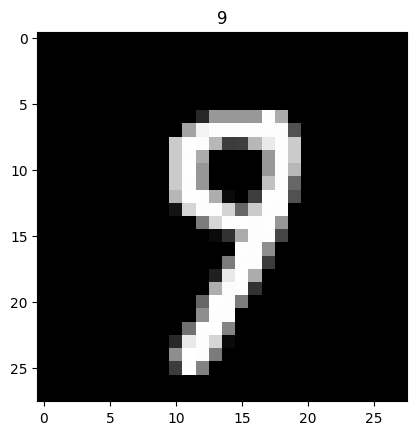

In [7]:
show_image(train_images, train_labels, 1250)

## Test data

- Test data will be used to validate how good our network performs on data it has never seen.
- MNIST provides 10000 test images, each 28x28.
- It's important to note that these should never be used in the training cycle. A 'test set' should never contain images the network has already seen during training. (read more: [Model Selection and Train/Validation/Test Sets](https://www.coursera.org/lecture/machine-learning/model-selection-and-train-validation-test-sets-QGKbr) and [How (and why) to create a good validation set](https://www.fast.ai/2017/11/13/validation-sets/))

### Exercise 2

**TODO**: Print the test images and test labels shape below:

In [8]:
test_images.shape

(10000, 28, 28)

In [9]:
test_labels.shape

(10000,)

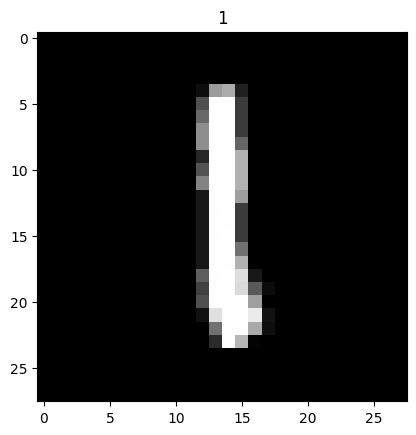

In [10]:
show_image(test_images, test_labels, 168)

# 3. Data Preparation

Before feeding the data into the network for training, we make sure it is formatted properly.

## Prepare the images

### Exercise 3
**TODO**: Reshape the images to vectors of integers

In [11]:
train_images_reshaped = train_images.reshape((60000, 28*28))
test_images_reshaped = test_images.reshape((10000, 28*28))

In [12]:
train_images_reshaped.shape

(60000, 784)

### Exercise 4
**TODO**: Resize the values to a value between 0 and 1

In [13]:
train_images_transformed = train_images_reshaped.astype('float32') / 255
test_images_transformed = test_images_reshaped.astype('float32') / 255

## Prepare the labels (one hot encoding)

In [14]:
from tensorflow.keras.utils import to_categorical
train_labels_categorical = to_categorical(train_labels)
test_labels_categorical = to_categorical(test_labels)

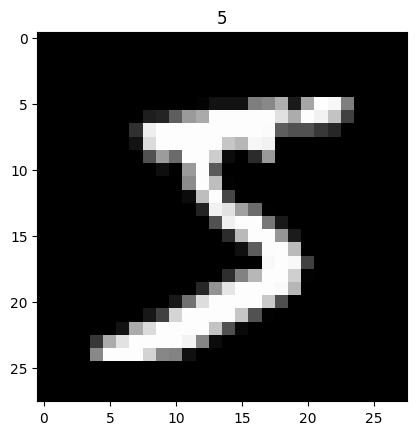

In [15]:
show_image(train_images, train_labels, 0)

In [16]:
train_labels

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [17]:
train_labels_categorical[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

# 4. Network architecture

Define the network architecture that will be used for training

- how many layers
- which type of layer
- how many nodes in each layer
- activation function in each layer


### Exercise 5

1. Start with the simple Neural Network below
2. Start trying out different hyperparameters
  
  a. Change the 'relu' activation function to 'sigmoid'. What happens? (run the cells below to see a difference in test results)

  b. What happens if you add hidden layers? (try the visual example of the slides with a first hidden layer of 300 neurons, and a second one with 100 neurons)

  c. What happens when you try different initializers
  
  b. Figure out how to add "Dropout" to the first layer of the network.

  d. What happens if you add L1 or L2 regularization to the activations?

=> Start with one regularization or optimization parameter at a time.

=> Experiment with extreme values

=> Every time you try something new, inspect the training cycle of the model and the accompanying graphs

In [18]:
network = models.Sequential()
network.add(layers.Dense(300, activation='relu', input_shape=(28 * 28,), kernel_regularizer=keras.regularizers.l1_l2(l1=0, l2=0.001)))
network.add(layers.Dense(100, activation='relu'))

# The final layer has 10 nodes, each node represents one class of numbers
network.add(layers.Dense(10, activation='softmax'))

# 5. Compilation Step

In the compilation step we define the:

- the loss function
- the optimizer
- the evaluation metric

In [19]:
network.compile(optimizer='SGD',
               loss='categorical_crossentropy',
               metrics=['accuracy'])

# 6. Network summary

In [20]:
network.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266610 (1.02 MB)
Trainable params: 266610 (1.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# 7. Train the network

Feed the training images and labels to the network.

Two additional parameters need to be supplied:

- epochs: how many times the network will look at the entire dataset.
- batch_size: how many images will be put through the network at one time.

### Exercise 7

- Can you train the network longer?
- What happens when you adjust the batch size?
- What happens to the training accuracy?
- And the test accuracy?
- Try adding an early stopping callback function and check the effect it has on your model

In [21]:
from keras.regularizers import *
from keras.callbacks import EarlyStopping

In [22]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
history = network.fit(train_images_transformed, train_labels_categorical,
                      validation_split=0.33,
                      epochs=10,
                      batch_size=128,
                      callbacks=[es])

Epoch 1/10
315/315 [==============================] - 9s 12ms/step - loss: 1.8246 - accuracy: 0.6628 - val_loss: 1.1736 - val_accuracy: 0.8330
Epoch 2/10
315/315 [==============================] - 5s 15ms/step - loss: 1.0181 - accuracy: 0.8573 - val_loss: 0.9149 - val_accuracy: 0.8725
Epoch 3/10
315/315 [==============================] - 3s 10ms/step - loss: 0.8636 - accuracy: 0.8852 - val_loss: 0.8176 - val_accuracy: 0.8923
Epoch 4/10
315/315 [==============================] - 2s 7ms/step - loss: 0.7989 - accuracy: 0.8969 - val_loss: 0.7734 - val_accuracy: 0.9020
Epoch 5/10
315/315 [==============================] - 1s 4ms/step - loss: 0.7597 - accuracy: 0.9051 - val_loss: 0.7448 - val_accuracy: 0.9075
Epoch 6/10
315/315 [==============================] - 1s 4ms/step - loss: 0.7314 - accuracy: 0.9107 - val_loss: 0.7193 - val_accuracy: 0.9127
Epoch 7/10
315/315 [==============================] - 1s 4ms/step - loss: 0.7087 - accuracy: 0.9163 - val_loss: 0.6998 - val_accuracy: 0.9159
Epo

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


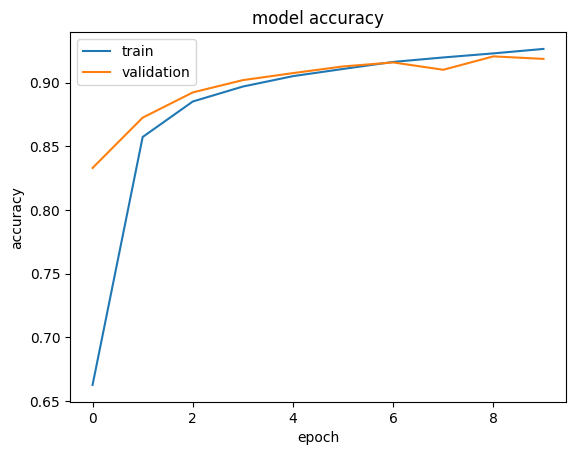

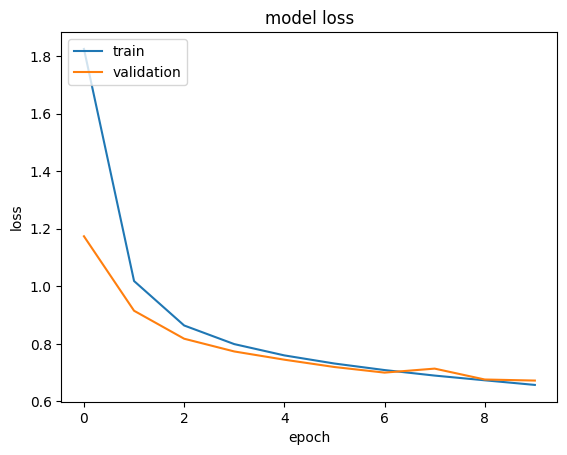

In [23]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# 8. Test the network

Use the test set (which the network has not seen yet) to test how well the network will perform on images it has not seen yet:

In [24]:
test_loss, test_acc = network.evaluate(test_images_transformed, test_labels_categorical)

313/313 [==============================] - 1s 2ms/step - loss: 0.6564 - accuracy: 0.9234


In [25]:
print('test_acc; ', test_acc)

test_acc;  0.9233999848365784


In [26]:
preds = np.argmax(network.predict(test_images_transformed), axis=1)
preds

313/313 [==============================] - 1s 2ms/step


array([7, 2, 1, ..., 4, 5, 6])

# 9. Export the network

Use the `save` function of Keras to export the network to a directory called `./temp`.

In [27]:
import os
network.save(os.path.join("./temp", network.name))

## ONNX
ONNX provides an open source format for AI models, both deep learning and traditional ML. It defines an extensible computation graph model, as well as definitions of built-in operators and standard data types. Currently we focus on the capabilities needed for inferencing (scoring).

ONNX is widely supported and can be found in many frameworks, tools, and hardware. Enabling interoperability between different frameworks and streamlining the path from research to production helps increase the speed of innovation in the AI community. We invite the community to join us and further evolve ONNX.

In [28]:
!pip install onnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 55.3 MB/s eta 0:00:00


## tf2onnx
tf2onnx converts TensorFlow (tf-1.x or tf-2.x), keras, tensorflow.js and tflite models to ONNX via command line or python api.

Note: tensorflow.js support was just added. While we tested it with many tfjs models from tfhub, it should be considered experimental.

TensorFlow has many more ops than ONNX and occasionally mapping a model to ONNX creates issues.

In [29]:
!pip install tf2onnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.7/455.7 kB 3.1 MB/s eta 0:00:00


## onnxruntime
ONNX Runtime is a performance-focused scoring engine for Open Neural Network Exchange (ONNX) models.

In [30]:
!pip install onnxruntime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 13.3 MB/s eta 0:00:00


Let's convert the model to the ONNX format and compare the predictions with the original model.

In [31]:
import tf2onnx
import onnxruntime as rt

spec = (tf.TensorSpec((None, 784), tf.float32, name="input"),)
output_path = network.name + ".onnx"

model_proto, _ = tf2onnx.convert.from_keras(network, input_signature=spec, opset=13, output_path=output_path)
output_names = [n.name for n in model_proto.graph.output]


In [32]:
providers = ['CPUExecutionProvider']
m = rt.InferenceSession(output_path, providers=providers)
onnx_pred =  np.argmax(m.run(output_names, {"input": test_images_transformed}), axis=2)
onnx_preds = onnx_pred[0]

# make sure ONNX and keras have the same results
np.testing.assert_allclose(preds, onnx_preds, rtol=1e-10)

preds_df = pd.DataFrame({'Keras model predictions': preds[:], 'ONNX model predictions': onnx_preds[:]})
#preds_df = pd.DataFrame(np.array([preds, onnx_pred[0]]), columns=['Keras model predictions', 'ONNX model predictions'])
preds_df

,Keras model predictions,ONNX model predictions
0,7,7
1,2,2
2,1,1
3,0,0
4,4,4
...,...,...
9995,2,2
9996,3,3
9997,4,4
9998,5,5


Let's make an archive of the model we saved via the Keras API.

In [38]:
!tar cvfz sequential.tar.gz temp/sequential

sample_data  sequential.onnx  sequential.tar.gz  temp
